In [81]:
# %matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict, Counter

from surprise import Reader, Dataset, accuracy
from surprise import SVD, SVDpp, NMF, SlopeOne, NormalPredictor, KNNBaseline, KNNBasic
from surprise import KNNWithMeans, BaselineOnly, CoClustering

from surprise.model_selection import GridSearchCV, KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [82]:
# Read in data
df = pd.read_csv('new_df.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
# Check for duplicated reviews
duplicated = df[df.duplicated(['customer_id', 'product_id'], keep=False)]

# Display duplicated
print('Number of duplications: {}'.format(duplicated.shape[0]))
pd.concat([df[df.duplicated(['customer_id', 'product_id'], keep=False)].head(2),
           df[df.duplicated(['customer_id', 'product_id'], keep=False)].tail(4)]
         )

Number of duplications: 6


,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,downvotes,total_votes,verified_purchase,review_headline,review_body,review_date,purchased_counts
2114,42884855,RJDCIQHVBYUWU,B0006AAS5G,1348996,Invicta Men's 9211 Speedway Collection Stainle...,Watches,1,6,3,9,N,buyer beware,I bought this watch from WATCH GRABBER....one ...,20/08/13,551
2115,42884855,R21UWBLLN4MZHJ,B0006AAS5G,1348996,Invicta Men's 9211 Speedway Collection Stainle...,Watches,1,1,3,4,N,buyer beware,I bought this watch from watch grabber....one ...,20/08/13,551
14268,40748179,R1ZUZQG7JCJ6DJ,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,5,0,0,0,Y,GREAT SHARPENER,made my knives even sharper then they factory ...,04/04/15,3970
14751,10364807,RR2UK60UKRJ5F,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,5,0,0,0,Y,Great product. Small enough to keep in pack wi...,Great product. Small enough to keep in pack w...,04/08/15,3970
14826,40748179,R1E7S4MAD0NCNJ,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,5,0,0,0,Y,Great little sharpener,GREAT SHARPENER! easy to use and gets my kniv...,25/08/15,3970
14827,10364807,R2719CSGEDXUU,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,5,0,0,0,Y,Five Stars,Works well,25/08/15,3970


In [83]:
# Drop duplicates
df = df[~df.duplicated(['customer_id', 'product_id'], keep=False)].reset_index().drop('index', axis=1)

# Sort df by customer_id and reset index
df = df.set_index('customer_id').sort_values('customer_id')
df = df.reset_index()

df.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,downvotes,total_votes,verified_purchase,review_headline,review_body,review_date,purchased_counts
0,10190,R15IHAZMBZWM6J,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,2,0,1,1,Y,I think the yellow smith's is better,I think the Yellow smith's sharpener is a bett...,04/05/14,3970
1,13604,R2QJO22RBESIIX,B0056C6XIA,186101103,Nokia X30,Mobiles,1,0,0,0,Y,One Star,The fire starter not good,29/10/14,177
2,14011,R3SSQKSK4JXXGD,B000AJIF4E,286542630,Sony MDR7506 Professional Large Diaphragm Head...,Musical Instruments,4,1,0,1,Y,"great sound, I'm used to some cheap twenty fiv...","great sound, I'm used to some cheap twenty fiv...",18/08/14,2209
3,17792,R1MWXHRRVNPZO1,B000G6R7B8,469687057,Seiko Men's SNK803 Seiko 5 Automatic Watch wit...,Watches,2,0,7,7,Y,Two Stars,Problems keeping the watch running if not worn...,04/07/14,558
4,18204,R28LPUSJNCX3XB,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,5,0,0,0,Y,Five Stars,GREAT,03/03/15,3970


# Simple Collaborative Filtering Recommendation System

The purpose of this simple collaborative filtering recommendation system is to show the inner workings behind a basic recommendation system. This recommendation system works behind the notion of:

"If you know my previous habits, you're assuming I'm going to stay that way for the rest of my life. You're trying to channel me into buying a product. I want to experience this world by stepping where I've never stepped before and buying something I never thought of buying."

The idea is to recommend items to a customer that the customer may not have thought of purchasing before. It's a refined way of browsing through products and not being hindered by a set of similar products. This recommendation system recommends products to a customer based on the rating they gave to a certain product. It filters through all other customers who have rated the product the same way and gives the most popular items purchased by these customers, essentially recommending products liked by similar customers.

## Thresholds

The datasets referenced have different minimum purchase counts per user (thresholds), which affect the speed and accuracy of the recommendation system. The thresholds are as follows:

- **df**: All users from one purchase and up.
- **Multiple**: All users from two purchases and up.
- **Many**: All users from three purchases and up.
- **Several**: All users from three purchases and up.

The changes in thresholds are due to the size of the datasets, unique customers, and unique products.

In [84]:
# Count how many times a customer purchased a product
counts = df['customer_id'].value_counts()

# Apply count filtering
multiple = df[df['customer_id'].isin(counts.index[counts>1])].reset_index().drop('index', axis=1)
several = df[df['customer_id'].isin(counts.index[counts>2])].reset_index().drop('index', axis=1)
many = df[df['customer_id'].isin(counts.index[counts>3])].reset_index().drop('index', axis=1)

# APR
print('Size of df: {:,}'.format(len(df)))
print('Unique df customers: {:,}'.format(len(df.customer_id.unique())))
print('Unique df products: {:,}'.format(len(df.product_id.unique())))
print('\n')

# Multiple
print('Size of multiple: {:,}'.format(len(multiple)))
print('Unique multiple customers: {:,}'.format(len(multiple.customer_id.unique())))
print('Unique multiple products: {:,}'.format(len(multiple.product_id.unique())))
print('\n')

# Several
print('Size of several: {:,}'.format(len(several)))
print('Unique several customers: {:,}'.format(len(several.customer_id.unique())))
print('Unique several products: {:,}'.format(len(several.product_id.unique())))
print('\n')

# Many
print('Size of many: {:,}'.format(len(many)))
print('Unique many customers: {:,}'.format(len(many.customer_id.unique())))
print('Unique many products: {:,}'.format(len(many.product_id.unique())))

Size of df: 39,267
Unique df customers: 38,357
Unique df products: 98


Size of multiple: 1,755
Unique multiple customers: 845
Unique multiple products: 97


Size of several: 183
Unique several customers: 59
Unique several products: 54


Size of many: 12
Unique many customers: 2
Unique many products: 8


# Simple Collaborative Filtering Recommendation System

The simple collaborative filtering recommendation system follows these steps to recommend products to a customer:

1. Takes in a dataset, user, and product.
2. Filters to all other users who have purchased the same product as the original user.
3. Filters to all users who gave the same rating as the original user.
4. Filters to all products those users purchased.
5. Filters to 5-star products those users purchased.
6. Selects the top 10 (or most common) products those users rated 5 stars.
7. Returns the recommended products.

This recommendation system informs a user about the products that users similar to them prefer. The recommendations are specific to the user and the product. The recommended products are not necessarily similar in nature.


In [85]:
def collab(dataset, customer_id, product_id):
    
    # Filter out original customer and retrieve only customers that purchased the same product
    user_condition = dataset.customer_id != customer_id # Not original customer
    product_condition = dataset.product_id == product_id # Is product
    ratings_by_others = dataset[user_condition & product_condition] # Other customers who purchased product
    if ratings_by_others.empty: # All products have at least 100 ratings
        return 'no matches'

    # Retrieve initial customer's rating
    user_rating = dataset[(dataset.customer_id == customer_id) & (dataset.product_id == product_id)].star_rating
    
    # Find only other customers that rated that product the same rating
    # If the customer gave the product a 2, it would find other customers that gave the product a 2, so on
    similar_user_ratings = ratings_by_others[user_rating.iloc[0] == ratings_by_others.star_rating]
    
    # Extract customer id of like-minded customers (same ratings as selected customer)
    similar_users = similar_user_ratings.customer_id
    
    # Retrieve all the like-minded customers' purchased products and ratings
    similar_user_products = dataset.loc[dataset.customer_id.isin(similar_users)]
    
    # Filter only the 5 star products of these customers
    five_star_products = similar_user_products[similar_user_products.star_rating == 5.0]

    # Sort 5 star products by how many other customers purchased that product
    top_products = five_star_products.product_id.value_counts().sort_values(ascending=False).index
    
    # Filter top 10 5 star products selected by customers who purchased the original customer's product
    top_10 = dataset.loc[dataset.product_id.isin(top_products[:10])].product_title.unique()
    print('---------------------------------------')
    print('{} other customers purchased this product.'.format(len(similar_users)))
    print('Similar customers purchased {} other products.'.format(len(five_star_products)))
    print('\nWe recommend these products from those similar customers:')
    for integer, product in enumerate(top_10):
        print(integer,' ', product)
    print('\n')

In [86]:
df.head()


,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,downvotes,total_votes,verified_purchase,review_headline,review_body,review_date,purchased_counts
0,10190,R15IHAZMBZWM6J,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,2,0,1,1,Y,I think the yellow smith's is better,I think the Yellow smith's sharpener is a bett...,04/05/14,3970
1,13604,R2QJO22RBESIIX,B0056C6XIA,186101103,Nokia X30,Mobiles,1,0,0,0,Y,One Star,The fire starter not good,29/10/14,177
2,14011,R3SSQKSK4JXXGD,B000AJIF4E,286542630,Sony MDR7506 Professional Large Diaphragm Head...,Musical Instruments,4,1,0,1,Y,"great sound, I'm used to some cheap twenty fiv...","great sound, I'm used to some cheap twenty fiv...",18/08/14,2209
3,17792,R1MWXHRRVNPZO1,B000G6R7B8,469687057,Seiko Men's SNK803 Seiko 5 Automatic Watch wit...,Watches,2,0,7,7,Y,Two Stars,Problems keeping the watch running if not worn...,04/07/14,558
4,18204,R28LPUSJNCX3XB,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,5,0,0,0,Y,Five Stars,GREAT,03/03/15,3970


In [87]:
# Find specific customer and product
df[df.product_id == 'B000AJIF4E'][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline']
].head(1)

,customer_id,product_id,product_title,product_category,star_rating,review_headline
2,14011,B000AJIF4E,Sony MDR7506 Professional Large Diaphragm Head...,Musical Instruments,4,"great sound, I'm used to some cheap twenty fiv..."


In [88]:
%%time

# Threshold: 1 or more purchases per customer
collab(df, 14011, 'B000AJIF4E')

---------------------------------------
294 other customers purchased this product.
Similar customers purchased 8 other products.

We recommend these products from those similar customers:
0   Oneplus 11 Pro 5g
1   Seiko Men's SNK809 Seiko 5 Automatic Stainless Steel Watch with Black Canvas Strap
2   Iphone 14
3   Oppo A17 5g
4   Sony MDR-W08L Vertical In-The-Ear Headphones
5   Boat E6 Portable Audio Headphone Amplifier
6   Boat X3 Mastering Quality Music Player w/ Wolfson DAC WM8740 24Bit 192K


CPU times: user 9.55 ms, sys: 1.38 ms, total: 10.9 ms
Wall time: 10 ms


In [89]:
# Find specific customer and product
df[df.purchased_counts == 102][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
].head(1)

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
642,1206438,B0071AKB38,X-Mini KAI XAM11-B Bluetooth Portable Capsule ...,Electronics,4,The speaker sound quality is very good and eas...,102


In [90]:
np.random.seed(10)
pivot = df.iloc[np.random.choice(df.index, size=10000, replace=False, )].pivot_table(
    index='customer_id', columns='product_id', values='star_rating', aggfunc='mean')

pivot.head(10)

product_id,140053271X,B00002N9ER,B00005N6KG,B000065BPB,B0000C9ZBW,B0001ARCFA,B0001MLMKY,B0002KZAKS,B0002TJGQS,B00062PN6I,...,B009UZBLSG,B00ACP3OOM,B00ADR2DTG,B00AH3DCAA,B00B9B4IYI,B00CW7KK9K,B00D3ITOHG,B00E9O6C96,B00H43WOAK,B00HVLUR18
customer_id,,,,,,,,,,,,,,,,,,,,,
10190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47709,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66011,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
def missing(dataset):
    columns = dataset.columns
    print('TOTAL RATINGS per PRODUCT: {}'.format(len(dataset)))
    print('MISSING RATINGS per PRODUCT')
    for column in columns:
        percentage = (dataset[column].isnull().sum() / len(dataset)) * 100
        print('{}: {}, {:0.2f}%'.format(column, dataset[column].isnull().sum(), percentage))
        if percentage < 99.99:
            break
        
def missing_row(dataset):
    indexes = dataset.index
    print('TOTAL RATINGS per CUSTOMER: {}'.format(len(dataset.columns)))
    print('MISSINGS RATINGS per CUSTOMER')
    for index in indexes:
        percentage = (dataset.loc[index].isnull().sum() / len(dataset.columns)) * 100
        print('{}: {}, {:0.2f}%'.format(index, dataset.loc[index].isnull().sum(), percentage))
        if index == 17858:
            break

In [92]:
missing(pivot)

TOTAL RATINGS per PRODUCT: 9938
MISSING RATINGS per PRODUCT
140053271X: 9788, 98.49%


In [93]:
missing_row(pivot)

TOTAL RATINGS per CUSTOMER: 98
MISSINGS RATINGS per CUSTOMER
10190: 97, 98.98%
19030: 97, 98.98%
20147: 97, 98.98%
32284: 97, 98.98%
47709: 97, 98.98%
54949: 97, 98.98%
60828: 97, 98.98%
66011: 97, 98.98%
67630: 97, 98.98%
76463: 97, 98.98%
76950: 97, 98.98%
77013: 97, 98.98%
80656: 97, 98.98%
98005: 97, 98.98%
111461: 97, 98.98%
117613: 97, 98.98%
119824: 97, 98.98%
120998: 97, 98.98%
126879: 97, 98.98%
129822: 97, 98.98%
131497: 97, 98.98%
134296: 97, 98.98%
141750: 97, 98.98%
144568: 97, 98.98%
159018: 97, 98.98%
159237: 97, 98.98%
174368: 97, 98.98%
191907: 97, 98.98%
200012: 97, 98.98%
208165: 97, 98.98%
215723: 97, 98.98%
219992: 97, 98.98%
241368: 97, 98.98%
243127: 97, 98.98%
245391: 97, 98.98%
247694: 97, 98.98%
255942: 97, 98.98%
259018: 97, 98.98%
260266: 97, 98.98%
261709: 97, 98.98%
268480: 97, 98.98%
274684: 97, 98.98%
279514: 97, 98.98%
297332: 97, 98.98%
297981: 97, 98.98%
301144: 97, 98.98%
311654: 97, 98.98%
318116: 97, 98.98%
326525: 97, 98.98%
336003: 97, 98.98%
346

In [94]:
# Find customers with the most purchases
customers = many.groupby('customer_id')['star_rating'].count()
top_customers = customers.sort_values(ascending=False)[:250]

# Find products with the most purchases
products = many.groupby('product_id')['star_rating'].count()
top_products = products.sort_values(ascending=False)[:10]

# Combine the datasets
join1 = many.join(top_customers, on='customer_id', how='inner', rsuffix='_r')
join1 = join1.join(top_products, on='product_id', how='inner', rsuffix='_r')

# Pivot the datset into a matrix
top_cust_prod = pd.crosstab(join1.customer_id, join1.product_id, join1.star_rating, aggfunc=np.mean)
top_cust_prod

product_id,B000B5MI3Q,B000B5OD4I,B000G6R7B8,B000LTAY1U,B000O8OTNC,B000OP1M6M,B002SSUQFG,B006CHML4I
customer_id,,,,,,,,
13355404,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
47820303,NaN,NaN,5.0,5.0,NaN,NaN,5.0,5.0


# Algorith Selection

In [95]:

# Take random sample of ratings from dataset
np.random.seed(10)
df_ = df.iloc[np.random.choice(df.index, size=10000, replace=False)]

# Set up rating scale and load data to be trained
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_[['customer_id', 'product_title', 'star_rating']], reader)

In [96]:
%%time

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), 
                  KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    # tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    # tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp['Algorithm'] = str(algorithm).split(' ')[0].split('.')[-1]
    benchmark.append(tmp)
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
CPU times: user 3.2 s, sys: 1.57 s, total: 4.77 s
Wall time: 5.57 s


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.187134,0.046640,0.007105
KNNBaseline,1.187987,0.409360,0.012078
BaselineOnly,1.188797,0.009278,0.006838
SVDpp,1.192805,0.027316,0.007397
KNNBasic,1.223291,0.352811,0.011752
CoClustering,1.225371,0.201781,0.005980
SlopeOne,1.225734,0.020719,0.007793
KNNWithMeans,1.226222,0.337453,0.009506
NMF,1.227210,0.248318,0.007487


SVD gives the best RMSE so we will move along with SVD. First we will evaluate this algorithm by cross validating it 3 times in the default settings.

In [97]:
# Cross validate default algorithm
algo = SVD(n_factors=100,
            n_epochs=20,
            biased=True,
            init_mean=0,
            init_std_dev=0.1,
            lr_all=0.005,
            reg_all=0.02,
            lr_bu=None,
            lr_bi=None,
            lr_pu=None,
            lr_qi=None,
            reg_bu=None,
            reg_bi=None,
            reg_pu=None,
            reg_qi=None,
            random_state=10)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

{'test_rmse': array([1.18086451, 1.19439682, 1.19796625]),
 'fit_time': (0.04810595512390137, 0.044861793518066406, 0.04483199119567871),
 'test_time': (0.006779193878173828,
  0.006810188293457031,
  0.006773948669433594)}

In [98]:
# Take random sample of ratings from dataset
np.random.seed(10)
df_ = df.iloc[np.random.choice(df.index, size=2000, replace=False)]

# Shuffle the index of df dataset for random split
idx = np.array(df_.index, dtype='int')
np.random.shuffle(idx)

# Start train-test-split with 80%-20% ratio
train = df_.loc[idx[:int(0.75*len(idx))],['customer_id', 'product_title', 'star_rating']]
test = df_.loc[idx[int(0.75*len(idx)):],['customer_id', 'product_title', 'star_rating']]

print("# of users in total:" , df_.customer_id.nunique())
print("# of users in the training set: ", train.customer_id.nunique())
print("# of products in total:" , df_.product_id.nunique())
print("# of products in the training set: ", train.product_title.nunique())

# of users in total: 1999
# of users in the training set:  1499
# of products in total: 98
# of products in the training set:  97


In [99]:
# Load trainset and testset into Surprise

# create a Reader object with the rating_scale from 1 to 5
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
# Load trainset, note: the columns must correspond to user id, item id and ratings in the exact order
data_train = Dataset.load_from_df(train, reader)

# Prepare a trainset object out of the training data to feed to .fit() method
training = data_train.build_full_trainset()

# Load testset
data_test = Dataset.load_from_df(test, reader)

# Prepare a testset object out of the test data to feed to .test() method
testing = data_test.construct_testset(data_test.raw_ratings)

In [100]:
%%time

# Hyperparameter optimization with scikit-surprise SVD algorithm

# Cross validation to optimize parameters of SVD with bias
param_grid = {'n_factors': [50,75,100,150], 
                'n_epochs': [10,20,50,100], 
                'lr_all': [0.002,0.005,0.007],
                'reg_all': [0.01,0.02,0.03,0.04]}

svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=KFold(3, random_state=10))
svd_gs.fit(data_train) # gridsesarch optimization on the trainset

# Best RMSE score
print(svd_gs.best_score)
# Combination of parameters that gave the best RMSE score
print(svd_gs.best_params)

{'rmse': 1.243648519700387}
{'rmse': {'n_factors': 150, 'n_epochs': 10, 'lr_all': 0.007, 'reg_all': 0.02}}
CPU times: user 7.27 s, sys: 25.1 ms, total: 7.3 s
Wall time: 7.3 s


In [101]:
%%time

# Update SVD model with optimized parameters
svd = SVD(n_factors=75, n_epochs=100, lr_all=0.002, reg_all=0.01, random_state=10)
svd.fit(training)
pred_svd = svd.test(testing)
print(accuracy.rmse(pred_svd))

RMSE: 1.2785
1.2784762234947322
CPU times: user 34.7 ms, sys: 1.08 ms, total: 35.8 ms
Wall time: 34.3 ms


In [102]:
%%time

# Load full dataset and split into train and test set to test hyperparameter on large dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['customer_id', 'product_title', 'star_rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

CPU times: user 127 ms, sys: 2.86 ms, total: 130 ms
Wall time: 129 ms


In [103]:
%%time

# Test default algorithm
algo = SVD(random_state=10)
predictions = algo.fit(trainset).test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.2074
1.2073788177922642
CPU times: user 254 ms, sys: 4.33 ms, total: 258 ms
Wall time: 257 ms


In [104]:
%%time

# Test tuned algorithm
algo_tuned = SVD(n_factors=75, n_epochs=100, lr_all=0.002, reg_all=0.01, random_state=10)
predictions_tuned = algo_tuned.fit(trainset).test(testset)
print(accuracy.rmse(predictions_tuned))

RMSE: 1.2077
1.2077460171028098
CPU times: user 817 ms, sys: 7.28 ms, total: 824 ms
Wall time: 823 ms


In [105]:
%%time

# Test re-tuned algorithm
algo_tuned = SVD(n_factors=100, n_epochs=20, lr_all=0.007, reg_all=0.04, random_state=10)
predictions_tuned = algo_tuned.fit(trainset).test(testset)
print(accuracy.rmse(predictions_tuned))

RMSE: 1.2073
1.207336491117188
CPU times: user 245 ms, sys: 3.46 ms, total: 248 ms
Wall time: 247 ms


In [106]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

# Create dataset for prediction evaluation
temp_df = pd.DataFrame(predictions_tuned, columns=['uid', 'iid', 'rui', 'est', 'details'])
temp_df['Iu'] = temp_df.uid.apply(get_Iu)
temp_df['Ui'] = temp_df.iid.apply(get_Ui)
temp_df['err'] = abs(temp_df.est - temp_df.rui)
best_predictions = temp_df.sort_values(by='err')[:10]
worst_predictions = temp_df.sort_values(by='err')[-10:]

In [107]:
best_predictions


,uid,iid,rui,est,details,Iu,Ui,err
3398,15021090,Zoom H4N Handy Portable Digital Recorder - 200...,5.0,5.000000,{'was_impossible': False},1,464,0.000000
1429,42458650,Seiko Men's SNK803 Seiko 5 Automatic Watch wit...,5.0,5.000000,{'was_impossible': False},1,427,0.000000
5104,22165265,Boat E17 Alpen Portable Headphone Amplifier US...,5.0,5.000000,{'was_impossible': False},2,207,0.000000
6261,21875075,Zoom H4N Handy Portable Digital Recorder - 200...,5.0,5.000000,{'was_impossible': False},1,464,0.000000
4531,47616402,Invicta Men's 3045 Pro-Diver Collection Grand ...,4.0,3.999324,{'was_impossible': False},1,148,0.000676
5181,11241042,Sony MDR-W08L Vertical In-The-Ear Headphones,4.0,3.998626,{'was_impossible': False},0,1008,0.001374
9011,39489454,Sony MDR-W08L Vertical In-The-Ear Headphones,4.0,3.998626,{'was_impossible': False},0,1008,0.001374
9441,12966203,Sony MDR-W08L Vertical In-The-Ear Headphones,4.0,3.998626,{'was_impossible': False},0,1008,0.001374
7590,52218960,Sony MDR-W08L Vertical In-The-Ear Headphones,4.0,3.998626,{'was_impossible': False},0,1008,0.001374
4815,39831575,Sony MDR-W08L Vertical In-The-Ear Headphones,4.0,3.998626,{'was_impossible': False},0,1008,0.001374


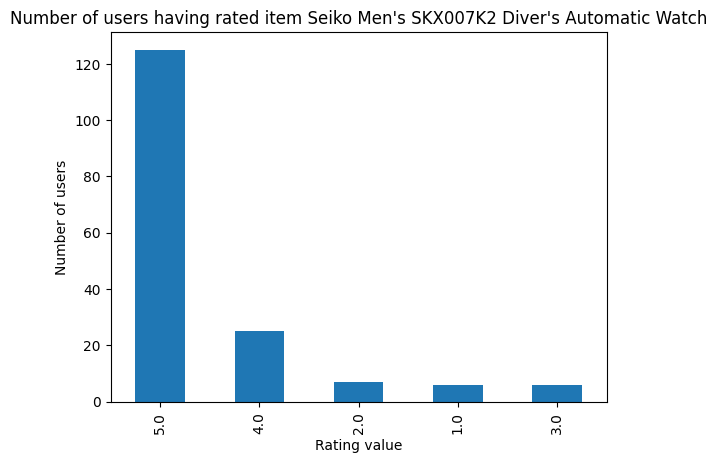

In [108]:
counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid("Seiko Men's SKX007K2 Diver's Automatic Watch")]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title("Number of users having rated item Seiko Men's SKX007K2 Diver's Automatic Watch")
plt.show()

In [109]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
5982,52075687,Seiko Men's SSC017 Prospex Analog Japanese Qua...,1.0,4.602150,{'was_impossible': False},0,179,3.602150
3614,40645844,Yonex badminton racquet,1.0,4.636603,{'was_impossible': False},0,900,3.636603
1956,19416946,Yonex badminton racquet,1.0,4.636603,{'was_impossible': False},0,900,3.636603
2148,22693337,Sony MDR7506 Professional Large Diaphragm Head...,1.0,4.638807,{'was_impossible': False},0,1626,3.638807
2275,45208779,Sony MDR7506 Professional Large Diaphragm Head...,1.0,4.638807,{'was_impossible': False},0,1626,3.638807
4879,19412590,Sony MDR7506 Professional Large Diaphragm Head...,1.0,4.638807,{'was_impossible': False},0,1626,3.638807
2051,51124218,Sony MDR7506 Professional Large Diaphragm Head...,1.0,4.638807,{'was_impossible': False},0,1626,3.638807
2833,10370343,Yonex badminton racquet,1.0,4.665933,{'was_impossible': False},1,900,3.665933
7638,10310551,Yonex badminton racquet,1.0,4.703935,{'was_impossible': False},1,900,3.703935
6475,25426039,Boat E11 Portable Headphone Amplifier - E11,1.0,4.809943,{'was_impossible': False},1,274,3.809943


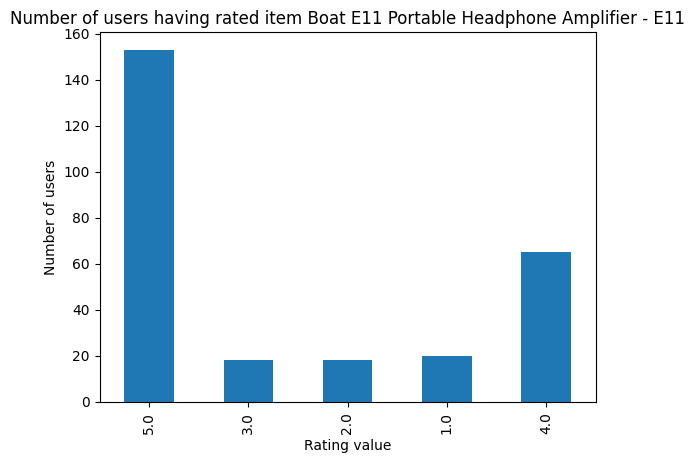

In [110]:
counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('Boat E11 Portable Headphone Amplifier - E11')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item Boat E11 Portable Headphone Amplifier - E11')
plt.show()

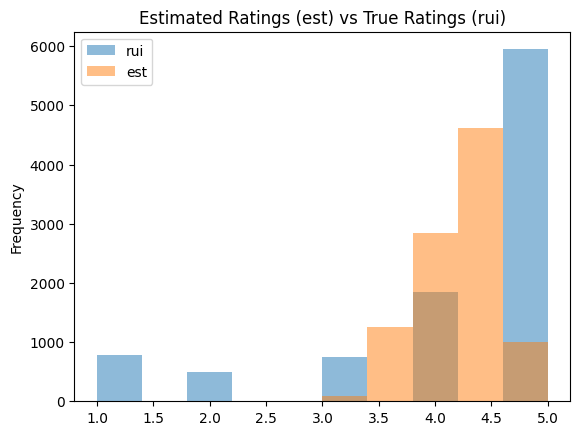

In [111]:
temp_df[['rui', 'est']].plot(kind='hist', alpha=0.5)
plt.title('Estimated Ratings (est) vs True Ratings (rui)')
plt.show()

# Recommending Products to a Customer
We'll now use the surprise module to find the top n products for each customer that we observe. We sample 10000 ratings because anything above kills our kernels or puts the notebook on a long hold for data processing and our computer may not be able to handle the computational strain. It does limit our prediction power but we have to give a little to get a little. To make predictions, we train our data and then predict for all pairs not in the training set.
## Building the Recommender

In [112]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [113]:
%%time

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.3975
0.397534817306171
CPU times: user 9.92 s, sys: 3.16 s, total: 13.1 s
Wall time: 14.5 s


In [114]:
# Find top n predictions
top_n = get_top_n(predictions, n=10)

# Print the recommended items for the first 5 users
counter = 0
for uid, user_ratings in top_n.items():
    if counter == 5:
        break
    print(uid, [iid for (iid, _) in user_ratings])
    counter += 1
    print('\n')

    
# Append recommended items for each user into a dictionary
top_items = {}
for uid, user_ratings in top_n.items():
    top_items[uid] = [iid for (iid, _) in user_ratings]

42973835 ['Yamaha YBA-11 Bluetooth Wireless Audio Receiver for Yamaha AV Products', 'Oppo A17 5g', 'Portronics RCA Component Video Cable -  6 Feet (1.8 Meters)', "KEEN Men's Newport Sandal", 'Portronics 24k Gold Connector Banana Plugs - 24-Pack (12 Red, 12 Black)', 'Sony MDR7506 Professional Large Diaphragm Headphone', 'Audio-Technica ATH-M20x Professional Monitor Headphones', 'Iphone 14', 'Marshall Headphones M-ACCS-00152 Monitor Headphones, Black', 'Condor Recon Chest Rig (Tan)']


17318258 ['Sony MDR7506 Professional Large Diaphragm Headphone', 'Portronics RCA Component Video Cable -  6 Feet (1.8 Meters)', "KEEN Men's Newport Sandal", 'Yonex badminton racquet', 'Vox amPlug Metal Guitar Headphone Amp', 'Portronics High-Speed HDMI Cable - 9.8 Feet (3 Meters) Supports 3D + Audio Return Channel', 'Audio-Technica ATH-M20x Professional Monitor Headphones', "Seiko Men's SNK805 Seiko 5 Automatic Stainless Steel Watch with Green Canvas", 'Macbook air M2', 'Iphone 13 pro']


51911785 ['Sony M

In [115]:
recommended_w_ratings = pd.DataFrame.from_dict(top_n, orient='index')
recommended_w_ratings.head()

,0,1,2,3,4,5,6,7,8,9
42973835,(Yamaha YBA-11 Bluetooth Wireless Audio Receiv...,"(Oppo A17 5g, 4.7009956495266385)",(Portronics RCA Component Video Cable - 6 Fee...,"(KEEN Men's Newport Sandal, 4.6719718069722695)",(Portronics 24k Gold Connector Banana Plugs - ...,(Sony MDR7506 Professional Large Diaphragm Hea...,(Audio-Technica ATH-M20x Professional Monitor ...,"(Iphone 14, 4.605424356938744)",(Marshall Headphones M-ACCS-00152 Monitor Head...,"(Condor Recon Chest Rig (Tan), 4.5870758384398..."
17318258,(Sony MDR7506 Professional Large Diaphragm Hea...,(Portronics RCA Component Video Cable - 6 Fee...,"(KEEN Men's Newport Sandal, 4.832146064315916)","(Yonex badminton racquet, 4.797640253625733)","(Vox amPlug Metal Guitar Headphone Amp, 4.7553...",(Portronics High-Speed HDMI Cable - 9.8 Feet (...,(Audio-Technica ATH-M20x Professional Monitor ...,(Seiko Men's SNK805 Seiko 5 Automatic Stainles...,"(Macbook air M2, 4.727150216070881)","(Iphone 13 pro, 4.722682902476082)"
51911785,(Sony MDR7506 Professional Large Diaphragm Hea...,(Portronics RCA Component Video Cable - 6 Fee...,"(Yonex badminton racquet, 4.5346630660556055)",(Behringer Ultravoice Xm8500 Dynamic Vocal Mic...,(Boat D3 (D03K) Digital to Analog Audio Conver...,"(KEEN Men's Newport Sandal, 4.478060678096688)",(Yamaha YBA-11 Bluetooth Wireless Audio Receiv...,(Swatch Women's GS124 Quartz Rainbow Dial Plas...,(Seiko Men's SSC017 Prospex Analog Japanese Qu...,"(Vox amPlug Metal Guitar Headphone Amp, 4.3731..."
2800173,(Sony MDR7506 Professional Large Diaphragm Hea...,(Yamaha YBA-11 Bluetooth Wireless Audio Receiv...,"(KEEN Men's Newport Sandal, 4.698029730609963)","(Macbook Air m2, 4.641488717064365)",(Bushnell Tour V2 with Pinseeker Laser Rangefi...,(Invicta Men's 9211 Speedway Collection Stainl...,"(Iphone 13 pro, 4.597028605896326)",(Audio-Technica ATH-M20x Professional Monitor ...,(Portronics RCA Component Video Cable - 6 Fee...,"(Vox amPlug Metal Guitar Headphone Amp, 4.5636..."
15533361,(Portronics RCA Component Video Cable - 6 Fee...,"(Yonex badminton racquet, 4.775262564876728)",(Seiko Men's SSC017 Prospex Analog Japanese Qu...,(Sony MDR7506 Professional Large Diaphragm Hea...,(Invicta Men's 6981 Pro Diver Analog Swiss Chr...,(Seiko Men's SNA411 Flight Alarm Chronograph W...,"(Seiko Men's SKX007K2 Diver's Automatic Watch,...",(Boat D3 (D03K) Digital to Analog Audio Conver...,(Marshall Headphones M-ACCS-00152 Monitor Head...,"(Condor Recon Chest Rig (Tan), 4.593670795083095)"


In [116]:
recommended = pd.DataFrame.from_dict(top_items, orient='index')
recommended.head()

,0,1,2,3,4,5,6,7,8,9
42973835,Yamaha YBA-11 Bluetooth Wireless Audio Receive...,Oppo A17 5g,Portronics RCA Component Video Cable - 6 Feet...,KEEN Men's Newport Sandal,Portronics 24k Gold Connector Banana Plugs - 2...,Sony MDR7506 Professional Large Diaphragm Head...,Audio-Technica ATH-M20x Professional Monitor H...,Iphone 14,Marshall Headphones M-ACCS-00152 Monitor Headp...,Condor Recon Chest Rig (Tan)
17318258,Sony MDR7506 Professional Large Diaphragm Head...,Portronics RCA Component Video Cable - 6 Feet...,KEEN Men's Newport Sandal,Yonex badminton racquet,Vox amPlug Metal Guitar Headphone Amp,Portronics High-Speed HDMI Cable - 9.8 Feet (3...,Audio-Technica ATH-M20x Professional Monitor H...,Seiko Men's SNK805 Seiko 5 Automatic Stainless...,Macbook air M2,Iphone 13 pro
51911785,Sony MDR7506 Professional Large Diaphragm Head...,Portronics RCA Component Video Cable - 6 Feet...,Yonex badminton racquet,Behringer Ultravoice Xm8500 Dynamic Vocal Micr...,Boat D3 (D03K) Digital to Analog Audio Convert...,KEEN Men's Newport Sandal,Yamaha YBA-11 Bluetooth Wireless Audio Receive...,Swatch Women's GS124 Quartz Rainbow Dial Plast...,Seiko Men's SSC017 Prospex Analog Japanese Qua...,Vox amPlug Metal Guitar Headphone Amp
2800173,Sony MDR7506 Professional Large Diaphragm Head...,Yamaha YBA-11 Bluetooth Wireless Audio Receive...,KEEN Men's Newport Sandal,Macbook Air m2,Bushnell Tour V2 with Pinseeker Laser Rangefinder,Invicta Men's 9211 Speedway Collection Stainle...,Iphone 13 pro,Audio-Technica ATH-M20x Professional Monitor H...,Portronics RCA Component Video Cable - 6 Feet...,Vox amPlug Metal Guitar Headphone Amp
15533361,Portronics RCA Component Video Cable - 6 Feet...,Yonex badminton racquet,Seiko Men's SSC017 Prospex Analog Japanese Qua...,Sony MDR7506 Professional Large Diaphragm Head...,Invicta Men's 6981 Pro Diver Analog Swiss Chro...,Seiko Men's SNA411 Flight Alarm Chronograph Watch,Seiko Men's SKX007K2 Diver's Automatic Watch,Boat D3 (D03K) Digital to Analog Audio Convert...,Marshall Headphones M-ACCS-00152 Monitor Headp...,Condor Recon Chest Rig (Tan)


In [117]:
def products_recommended(user):
    print('The top 10 product recommendations for user {} is:'.format(user))
    return recommended.loc[user]

def products_recommended_w_rating(user):
    number = 0
    print('The top 10 product recommendations with estimated ratings for user {} is:'.format(user))
    for rating in recommended_w_ratings.loc[user]:
        print(number,' ', rating[0], ' : ', rating[1])
        number += 1

In [118]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,downvotes,total_votes,verified_purchase,review_headline,review_body,review_date,purchased_counts
0,10190,R15IHAZMBZWM6J,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,2,0,1,1,Y,I think the yellow smith's is better,I think the Yellow smith's sharpener is a bett...,04/05/14,3970
1,13604,R2QJO22RBESIIX,B0056C6XIA,186101103,Nokia X30,Mobiles,1,0,0,0,Y,One Star,The fire starter not good,29/10/14,177
2,14011,R3SSQKSK4JXXGD,B000AJIF4E,286542630,Sony MDR7506 Professional Large Diaphragm Head...,Musical Instruments,4,1,0,1,Y,"great sound, I'm used to some cheap twenty fiv...","great sound, I'm used to some cheap twenty fiv...",18/08/14,2209
3,17792,R1MWXHRRVNPZO1,B000G6R7B8,469687057,Seiko Men's SNK803 Seiko 5 Automatic Watch wit...,Watches,2,0,7,7,Y,Two Stars,Problems keeping the watch running if not worn...,04/07/14,558
4,18204,R28LPUSJNCX3XB,B000O8OTNC,826484350,Oneplus 11 Pro 5g,Mobiles,5,0,0,0,Y,Five Stars,GREAT,03/03/15,3970


In [119]:
df[df.customer_id == 17792][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
]

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
3,17792,B000G6R7B8,Seiko Men's SNK803 Seiko 5 Automatic Watch wit...,Watches,2,Two Stars,558


In [120]:
products_recommended_w_rating(17792)

The top 10 product recommendations with estimated ratings for user 17792 is:
0   Macbook air M2  :  4.635063791599292
1   Invicta Men's 3044 Stainless Steel Grand Diver Automatic Watch  :  4.618893098658571
2   Boat D3 (D03K) Digital to Analog Audio Converter - 192kHz/24bit Optical and Coaxial DAC  :  4.583756648185764
3   Invicta Men's 6981 Pro Diver Analog Swiss Chronograph Black Polyurethane Watch  :  4.576200018421128
4   Barnes & Noble Nook Simple Touch eBook Reader (Wi-Fi Only)  :  4.5128524723107395
5   AKG Pro Audio K702 Channel Studio Headphones  :  4.5063355414602615
6   Seiko Men's SSC017 Prospex Analog Japanese Quartz Solar Stainless Steel Dive Watch  :  4.4965468782628255
7   KEEN Men's Newport Sandal  :  4.489118880507877
8   Samsung S23 ultra  :  4.480133523877061
9   Yonex badminton racquet  :  4.470937533998145


In [121]:
products_recommended(17792)

The top 10 product recommendations for user 17792 is:


0                                       Macbook air M2
1    Invicta Men's 3044 Stainless Steel Grand Diver...
2    Boat D3 (D03K) Digital to Analog Audio Convert...
3    Invicta Men's 6981 Pro Diver Analog Swiss Chro...
4    Barnes & Noble Nook Simple Touch eBook Reader ...
5         AKG Pro Audio K702 Channel Studio Headphones
6    Seiko Men's SSC017 Prospex Analog Japanese Qua...
7                            KEEN Men's Newport Sandal
8                                    Samsung S23 ultra
9                              Yonex badminton racquet
Name: 17792, dtype: object

In [122]:
df[df.customer_id == 18204][
    ['customer_id', 'product_id', 'product_title', 'product_category', 
     'star_rating', 'review_headline', 'purchased_counts']
]

,customer_id,product_id,product_title,product_category,star_rating,review_headline,purchased_counts
4,18204,B000O8OTNC,Oneplus 11 Pro 5g,Mobiles,5,Five Stars,3970


In [123]:
products_recommended(18204)

The top 10 product recommendations for user 18204 is:


0                                    Samsung S23 ultra
1    Portronics RCA Component Video Cable -  6 Feet...
2    Invicta Men's 2770 "Force Collection" Stainles...
3    Boat D3 (D03K) Digital to Analog Audio Convert...
4    AKG M220 Pro Stylist Semi-Open High Definition...
5     Seiko Men's SSC021 Solar Diver Chronograph Watch
6                Vox amPlug Metal Guitar Headphone Amp
7    Seiko Men's SSC017 Prospex Analog Japanese Qua...
8                            KEEN Men's Newport Sandal
9                                       Macbook Air m2
Name: 18204, dtype: object

In [124]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Load sampled 10000 ratings dataset
data = Dataset.load_from_df(df_[['customer_id', 'product_id', 'star_rating']], reader)
kf = KFold(n_splits=5)
algo = SVD(random_state=10)

print('Sampled 10000 Ratings \n')

number = 0
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print('KFold Test #{}:'.format(number+1))
    print('Precision: {}'.format(sum(prec for prec in precisions.values()) / len(precisions)))
    print('Recall: {}'.format(sum(rec for rec in recalls.values()) / len(recalls)))
    print('\n')
    number += 1

Sampled 10000 Ratings 



KFold Test #1:
Precision: 0.8625
Recall: 0.7875


KFold Test #2:
Precision: 0.88
Recall: 0.775


KFold Test #3:
Precision: 0.8225
Recall: 0.8075


KFold Test #4:
Precision: 0.855
Recall: 0.84


KFold Test #5:
Precision: 0.885
Recall: 0.7675




In [125]:
# Load full dataset
data = Dataset.load_from_df(df[['customer_id', 'product_id', 'star_rating']], reader)
kf = KFold(n_splits=5)
algo = SVD(random_state=10)

print('Full Dataset \n')
number = 0
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print('KFold Test #{}:'.format(number+1))
    print('Precision: {}'.format(sum(prec for prec in precisions.values()) / len(precisions)))
    print('Recall: {}'.format(sum(rec for rec in recalls.values()) / len(recalls)))
    print('\n')
    number += 1

Full Dataset 

KFold Test #1:
Precision: 0.8874952003071803
Recall: 0.8321387431204403


KFold Test #2:
Precision: 0.8775105539209416
Recall: 0.8354227964692337


KFold Test #3:
Precision: 0.8769693864480594
Recall: 0.8403355962597668


KFold Test #4:
Precision: 0.8860289409655525
Recall: 0.8260340632603407


KFold Test #5:
Precision: 0.8726330603889457
Recall: 0.8486011600136472




In [126]:
# Create simple id to map products
df['id'] = df.groupby('product_id').ngroup()

# Train the algortihm to compute the similarities between items
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['customer_id', 'id', 'star_rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [127]:
# Read the mappings raw id <-> product name
rid_to_name = dict(zip(df.id, df.product_title))
name_to_rid = dict(zip(df.product_title, df.id))

In [128]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Boat E17 Alpen Portable Headphone Amplifier USB DAC']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of Toy Story.
product_neighbors = algo.get_neighbors(product_inner_id, k=4)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 4 most similar products to Boat E17 Alpen Portable Headphone Amplifier USB DAC are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, df[df['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 4 most similar products to Boat E17 Alpen Portable Headphone Amplifier USB DAC are:

0: Electronics -  Boat E6 Portable Audio Headphone Amplifier
1: Electronics -  Boat E7 USB DAC and Portable Headphone Amplifier (Black)
2: Electronics -  Boat X3 Mastering Quality Music Player w/ Wolfson DAC WM8740 24Bit 192K
3: Electronics -  Boat E11 Portable Headphone Amplifier - E11


In [129]:
# Retrieve inner id of the product
product_raw_id = name_to_rid["Seiko Men's SKX007K2 Diver's Automatic Watch"]
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=4)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print("The 4 most similar products to Seiko Men's SKX007K2 Diver's Automatic Watch are:\n")
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, df[df['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 4 most similar products to Seiko Men's SKX007K2 Diver's Automatic Watch are:

0: Watches -  Seiko Men's SKX009K2 Diver's Analog Automatic Stainless Steel Watch
1: Watches -  Seiko Men's SNK809 Seiko 5 Automatic Stainless Steel Watch with Black Canvas Strap
2: Watches -  Seiko Men's SNK807 Seiko 5 Automatic Stainless Steel Watch with Blue Canvas Band
3: Watches -  Seiko Men's SKX007K Diver's Automatic Watch
